In [17]:
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt

In [18]:
# zapobieganie wypisywania notacji naukowej przez numpy
np.set_printoptions(suppress=True)

https://stat.gov.pl/obszary-tematyczne/ceny-handel/wskazniki-cen/wskazniki-cen-towarow-i-uslug-konsumpcyjnych-pot-inflacja-/miesieczne-wskazniki-cen-towarow-i-uslug-konsumpcyjnych-od-1982-roku/

In [19]:
def showRegressionMetricks(y_train, y_test, predicted_train, predicted_test):
  # Calculate regression metrics
  train_mse = mean_squared_error(y_train, predicted_train)
  test_mse = mean_squared_error(y_test, predicted_test)

  train_mae = mean_absolute_error(y_train, predicted_train)
  test_mae = mean_absolute_error(y_test, predicted_test)

  train_r2 = r2_score(y_train, predicted_train)
  test_r2 = r2_score(y_test, predicted_test)

  print(f"MSE na danych treningowych: {train_mse}")
  print(f"R2 Score na danych treningowych: {train_r2}")
  print(f"Mean Absolute Error na danych treningowych: {train_mae}")

  print(f"MSE na danych testowych: {test_mse}")
  print(f"R2 Score na danych testowych: {test_r2}")
  print(f"Mean Absolute Error na danych testowych: {test_mae}")

In [20]:
def testMLPRegressionModel(model, X_train, X_test, y_train, y_test, plot=True, toPrint=True):
  model.fit(X_train, y_train)
  predicted_train = model.predict(X_train)
  predicted_test = model.predict(X_test)
  if toPrint:
    print('Train score:', model.score(X_train, y_train))
    print('Test score:', model.score(X_test, y_test))

    showRegressionMetricks(y_train, y_test, predicted_train, predicted_test)

  if plot:
    plt.plot(predicted_train, color="gray", label="Rzeczywista inflacja")
    plt.plot(y_train, color="red", label="Przewidywana inflacja")
    plt.title("Przewidywanie inflacji - dane trenujące")
    plt.show()

    plt.plot(predicted_test, color="gray", label="Rzeczywista inflacja")
    plt.plot(y_test, color="red", label="Przewidywana inflacja")
    plt.title("Przewidywanie inflacji - dane testowe")
    plt.show()

  return mean_absolute_error(y_train, predicted_train)

# Zbieranie danych

### Załadowanie pliku z google drive

In [21]:
### Załadowanie dysku
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
data_file = "/content/drive/My Drive/Colab Notebooks/miesieczne_wskazniki_cen_towarow_i_uslug_konsumpcyjnych_od_1982_roku.xlsx"

### Załadowanie pliku z dysku

In [23]:
# from google.colab import files
# uploaded = files.upload()
# data_file = list(uploaded.keys())[0]

In [24]:
try:
  df = pd.read_excel(data_file)
  if "Sposób prezentacji" in df.columns:
      # Filtrowanie danych
      df_poprzedni_miesiac_100 = df[df["Sposób prezentacji"] == "Poprzedni miesiąc = 100"].copy()

      print("Wczytano dane i przefiltrowano według 'Sposób prezentacji' = 'Poprzedni miesiąc=100'.")
  else:
      print("Kolumna 'Sposób prezentacji' nie została znaleziona w pliku Excel.")
except FileNotFoundError:
    print(f"Błąd: Plik nie znaleziony pod ścieżką {data_file}")
except Exception as e:
    print(f"Wystąpił błąd podczas wczytywania pliku: {e}")

Wczytano dane i przefiltrowano według 'Sposób prezentacji' = 'Poprzedni miesiąc=100'.


### Filtracja danych

In [25]:
# TODO: sprawdz co oznacza Flaga 'a' w roku 2000 i 2001
#df_poprzedni_miesiac_100[["Sposób prezentacji", "Rok", "Miesiąc", "Wartość", "Flaga"]]
data = df_poprzedni_miesiac_100[["Rok", "Miesiąc", "Wartość"]]
# pozbywamy się wierszy z wartościami NaN, występujące w roku 2025
data = data.dropna(subset=["Wartość"])
data = data.sort_values(by=['Rok','Miesiąc'], ascending=[1,1])

data_array = data.to_numpy()
# print(data.head(20))

Mając różnice pomiędzy następnymi miesiącami, ustawiamy oulinery, które pokazują dużą różnicę inflacji, na wartość z miesiąca poprzedzającego je.

In [26]:
# średnia arytmetyczna
mean = np.mean(data_array[:, 2:3], axis=0)
# odchylenie standardowe
sd = np.std(data_array[:, 2:3], axis=0)
top_limit = mean + 2 * sd
bottom_limit = mean - 3 * sd

# wypiszmy dane, które zostaną usunięte (outliery)
data_array_filtered = list()
prev = 100
for row in data_array:
  data = row
  if (row[2] <= bottom_limit) or (row[2] >= top_limit):
    data[2] = prev
  prev = data[2]
  data_array_filtered.append(data)

# data_array_filtered = [row for row in data_array if (row[2] > bottom_limit)]
# data_array_filtered = [row for row in data_array_filtered if (row[2] < top_limit)]

# Przygotowywanie danych

inclacja - gdy "Wartość" > 100

deflacja - gdy "Wartość" < 100

#### Absolutna inflacja z rokiem i miesiącem

In [27]:
# kolumna 0, rok
# kolumna 1, miesiąc
# kolumna 2, wartość względem grudnia 1981
data_absolute_inflation = np.zeros((len(data_array), 3))
absolute_result = 1.0
idx = 0
for row in data_array:
  absolute_result = absolute_result + absolute_result * ((float(row[2])-100.0) / 100.0)
  data_absolute_inflation[idx] = [int(row[0]), int(row[1]), absolute_result]
  idx += 1
print(data_absolute_inflation)

[[1982.            1.            1.066     ]
 [1982.            2.            1.136356  ]
 [1982.            3.            1.20226465]
 ...
 [2025.            2.          504.53680396]
 [2025.            3.          505.54587756]
 [2025.            4.          507.56806107]]


#### Absolutna inflacja z kolejnością miesięcy

In [28]:
# kolumna 0, ilość miesięcy od grudnia 1982 (1 = dla styczeń 1982, 2 dla luty 1982, ..., 13 dla styczeń 1983, itd.)
# kolumna 1, wartość względem grudnia 1981
data_absolute_date_inflation = np.zeros((len(data_array), 2))
absolute_result = 1.0
idx = 0
for row in data_array:
  absolute_result = absolute_result + absolute_result * ((float(row[2])-100.0) / 100.0)
  data_absolute_date_inflation[idx] = [(int(row[0])-1982)*12 + int(row[1]), absolute_result]
  idx += 1
print(data_absolute_date_inflation)

[[  1.           1.066     ]
 [  2.           1.136356  ]
 [  3.           1.20226465]
 ...
 [518.         504.53680396]
 [519.         505.54587756]
 [520.         507.56806107]]


#### Pomocne funkcje zwracające przedziały danych

In [29]:
## Zaczynając od podanego miesiąca, zwraca dane z poprzednich miesięcy w postaci:
## [ostatnie miesiące], [ich inflacje]
# def getData_of_last_months(month, number_of_months):
#   if month - number_of_months <= 0:
#     raise Exception("Nie można pobrać danych przed 1982 rokiem. Podaj późniejszy miesiąc, lub zmniejsz ilość miesięcy, którą chcesz pobrać.")
#     return
#   months = np.zeros((number_of_months, 1))
#   inflation = np.zeros((number_of_months, 1))
#   for i in range(number_of_months):
#     index = int((month - number_of_months) + i - 1)
#     months[i] = index
#     inflation[i] = data_array_filtered[index][2]
#   return months, inflation

# Zaczynając od podanego miesiąca, zwraca dane z poprzednich miesięcy w postaci:
# [ostatnie miesiące], [ich inflacje]
def getInflation_of_last_months(month, number_of_months):
  if month - number_of_months <= 0:
    raise Exception("Nie można pobrać danych przed 1982 rokiem. Podaj późniejszy miesiąc, lub zmniejsz ilość miesięcy, którą chcesz pobrać.")
    return
  inflation = np.zeros((number_of_months, 1))
  for i in range(number_of_months):
    inflation[i] = data_array_filtered[(month - number_of_months) + i - 1][2]
  return inflation

def getInflation_of_last_months_unfiltered(month, number_of_months):
  if month - number_of_months <= 0:
    raise Exception("Nie można pobrać danych przed 1982 rokiem. Podaj późniejszy miesiąc, lub zmniejsz ilość miesięcy, którą chcesz pobrać.")
    return
  inflation = np.zeros((number_of_months, 1))
  for i in range(number_of_months):
    inflation[i] = data_array[(month - number_of_months) + i - 1][2]
  return inflation


# Sprawdzanie parametrów MLP Regression

#### Podział danych na uczące i testujące

Podział danych na 80% danych uczących, tj. od styczeń 1882 do września 2016 roku.

In [30]:
PROCENT_DANYCH_UCZACYCH = 0.8
ILOSC_DNI_POPRZEDNICH = 11
X, y = [], []
for i in range(ILOSC_DNI_POPRZEDNICH+2, len(data_array_filtered)):
  X.append(getInflation_of_last_months(i-1, ILOSC_DNI_POPRZEDNICH).flatten())
  y.append(data_array_filtered[i][2])
X = np.array(X) # inflacje w poprzednich miesiącach, np. [[inflacja_styczen, inflacja_luty]]
y = np.array(y) # inflacja w aktualnym miesiącu      np. [inflacja_marzec]

x_len = int(len(X) * PROCENT_DANYCH_UCZACYCH)
y_len = int(len(y) * PROCENT_DANYCH_UCZACYCH)
X_train = X[:x_len]
X_test = X[x_len:]
y_train = y[:y_len]
y_test = y[y_len:]

X, y = [], []
for i in range(ILOSC_DNI_POPRZEDNICH+2, len(data_array)):
  X.append(getInflation_of_last_months_unfiltered(i-1, ILOSC_DNI_POPRZEDNICH).flatten())
  y.append(data_array[i][2])
X = np.array(X) # inflacje w poprzednich miesiącach, np. [[inflacja_styczen, inflacja_luty]]
y = np.array(y) # inflacja w aktualnym miesiącu      np. [inflacja_marzec]

x_len_unf = int(len(X) * PROCENT_DANYCH_UCZACYCH)
y_len_unf = int(len(y) * PROCENT_DANYCH_UCZACYCH)
X_train_unf = X[:x_len_unf]
X_test_unf = X[x_len_unf:]
y_train_unf = y[:y_len_unf]
y_test_unf = y[y_len_unf:]

#### Udowodnienie, że filtracja oulinerów pomaga w trenowaniu

Uczenie modelu na danych przefiltrowanych

In [31]:
model = MLPRegressor(solver="adam", activation="relu", hidden_layer_sizes=(11,250,8), max_iter=2000)
testMLPRegressionModel(model, X_train, X_test, y_train, y_test, plot=False)

Train score: 0.5201816014448098
Test score: -0.046157175797998606
MSE na danych treningowych: 2.2323551797231134
R2 Score na danych treningowych: 0.5201816014448098
Mean Absolute Error na danych treningowych: 0.8752112371474551
MSE na danych testowych: 0.404461820227109
R2 Score na danych testowych: -0.046157175797998606
Mean Absolute Error na danych testowych: 0.45710008453585804


0.8752112371474551

Uczenie modelu na danych nie przefiltrowanych

In [32]:
model = MLPRegressor(solver="adam", activation="relu", hidden_layer_sizes=(11,250,8), max_iter=2000)
testMLPRegressionModel(model, X_train_unf, X_test_unf, y_train_unf, y_test_unf, plot=False)

Train score: 0.5348399099193646
Test score: -0.4210893956119104
MSE na danych treningowych: 2.1641573970876737
R2 Score na danych treningowych: 0.5348399099193646
Mean Absolute Error na danych treningowych: 0.8527123032035829
MSE na danych testowych: 0.5494168724849605
R2 Score na danych testowych: -0.4210893956119104
Mean Absolute Error na danych testowych: 0.5505051087179967


0.8527123032035829

#### Ustalenie najlepszej długości okna miesięcy

In [33]:
def getInflation_givenWindowSize(windowSize):
  PROCENT_DANYCH_UCZACYCH = 0.8
  ILOSC_DNI_POPRZEDNICH = windowSize
  X, y = [], []
  for i in range(ILOSC_DNI_POPRZEDNICH+2, len(data_array_filtered)):
    X.append(getInflation_of_last_months(i-1, ILOSC_DNI_POPRZEDNICH).flatten())
    y.append(data_array_filtered[i][2])
  X = np.array(X) # inflacje w poprzednich miesiącach, np. [[inflacja_styczen, inflacja_luty]]
  y = np.array(y) # inflacja w aktualnym miesiącu      np. [inflacja_marzec]

  x_len = int(len(X) * PROCENT_DANYCH_UCZACYCH)
  y_len = int(len(y) * PROCENT_DANYCH_UCZACYCH)
  X_train = X[:x_len]
  X_test = X[x_len:]
  y_train = y[:y_len]
  y_test = y[y_len:]
  return X_train, X_test, y_train, y_test

In [41]:
mses = [list(), list(), list(), list()]
modelsTest = list()
modelsTest.append(MLPRegressor(solver="adam", hidden_layer_sizes=(260, 150, 85), max_iter=2000))
modelsTest.append(MLPRegressor(solver="adam", hidden_layer_sizes=(150, 400, 150), max_iter=2000))
modelsTest.append(MLPRegressor(solver="adam", hidden_layer_sizes=(64, 64, 64), max_iter=2000))
modelsTest.append(MLPRegressor(solver="adam", hidden_layer_sizes=(250, 250, 250), max_iter=2000))

minMSE = np.inf
best_windowSize = 0
minMonths = 2
maxMonths = 30
meanIterations = 10
for modelIdx in range(len(mses)):
  for windowSize in range(minMonths, maxMonths):
    X_train, X_test, y_train, y_test = getInflation_givenWindowSize(windowSize)
    mse = 0.0
    for _ in range(meanIterations):
      model = modelsTest[modelIdx]
      mse += testMLPRegressionModel(model, X_train, X_test, y_train, y_test, plot=False, toPrint=False)
    mse = mse / float(meanIterations)
    mses[modelIdx].append(mse)
    if minMSE > mse:
      minMSE = mse
      best_windowSize = windowSize

print(minMSE)
print(best_windowSize)

0.8398237223429866
18


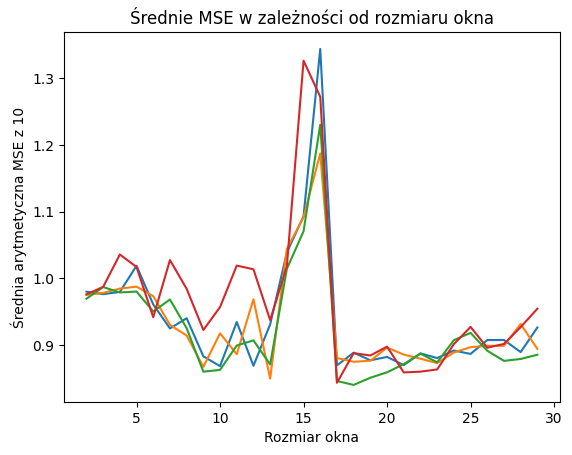

In [42]:
plt.plot(np.arange(minMonths, maxMonths), mses[0])
plt.plot(np.arange(minMonths, maxMonths), mses[1])
plt.plot(np.arange(minMonths, maxMonths), mses[2])
plt.plot(np.arange(minMonths, maxMonths), mses[3])
plt.xlabel("Rozmiar okna")
plt.ylabel(f"Średnia arytmetyczna MSE z {meanIterations}")
plt.title("Średnie MSE w zależności od rozmiaru okna")
plt.show()

# Budowa i trenowanie modelu aproksymacji MLP Regression

#### Sprawdzanie hyperparametrów korzystając z Optuna

In [ ]:
!pip install --quiet optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 15.7 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
  params = {
      # 'solver': trial.suggest_categorical("solver", ["adam", "lbfgs"]),
      'learning_rate_init': trial.suggest_float('learning_rate_init ', 0.0001, 0.1, step=0.005),  # aby przyspieszyc uczenie
      'first_layer_neurons': trial.suggest_int('first_layer_neurons', 10, 500, step=25),
      'second_layer_neurons': trial.suggest_int('second_layer_neurons',25, 2000, step=25),
      'third_layer_neurons': trial.suggest_int('third_layer_neurons', 10, 500, step=25),
      # 'third_layer_neurons': trial.suggest_int('third_layer_neurons', 10, 500, step=25),
      'activation': trial.suggest_categorical('activation', ['identity', 'relu']),
      'max_iter': trial.suggest_int('max_iter', 2000, 4000, step=150)
  }

  model = MLPRegressor(
      # solver=params['solver'],
      hidden_layer_sizes=(params['first_layer_neurons'], params['second_layer_neurons'], params['third_layer_neurons']),
      learning_rate_init=params['learning_rate_init'],
      activation=params['activation'],
      random_state=1,
      max_iter=params['max_iter']
  )

  model.fit(X_train, y_train)

  return mean_squared_error(y_train, model.predict(X_train)) # model.score(X_train, y_train)

study = optuna.create_study(direction='minimize') #maximize
study.optimize(objective, n_trials=500)

trial = study.best_trial
print("Accuracy: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2025-06-19 14:59:29,679] A new study created in memory with name: no-name-4c6ee8e1-2852-4c5b-ae10-7e9a1b33d8e4
[I 2025-06-19 14:59:34,658] Trial 0 finished with value: 58.11401327365921 and parameters: {'learning_rate_init ': 0.040100000000000004, 'first_layer_neurons': 160, 'second_layer_neurons': 950, 'third_layer_neurons': 235, 'activation': 'identity', 'max_iter': 2700}. Best is trial 0 with value: 58.11401327365921.
[I 2025-06-19 14:59:35,785] Trial 1 finished with value: 12754053.520743063 and parameters: {'learning_rate_init ': 0.035100000000000006, 'first_layer_neurons': 135, 'second_layer_neurons': 1775, 'third_layer_neurons': 60, 'activation': 'identity', 'max_iter': 3800}. Best is trial 0 with value: 58.11401327365921.
[I 2025-06-19 14:59:46,099] Trial 2 finished with value: 2.894897942478477 and parameters: {'learning_rate_init ': 0.0251, 'first_layer_neurons': 385, 'second_layer_neurons': 475, 'third_layer_neurons': 460, 'activation': 'identity', 'max_iter': 3100}. Best

Accuracy: 1.4966042377512747
Best hyperparameters: {'learning_rate_init ': 0.0251, 'first_layer_neurons': 260, 'second_layer_neurons': 150, 'third_layer_neurons': 85, 'activation': 'relu', 'max_iter': 2300}


Train score: 0.5166785830242541
Test score: -0.0890366396480522
MSE na danych treningowych: 1.667905583444264
R2 Score na danych treningowych: 0.5166785830242541
Mean Absolute Error na danych treningowych: 0.7316819263406783
MSE na danych testowych: 0.4274425249153021
R2 Score na danych testowych: -0.0890366396480522
Mean Absolute Error na danych testowych: 0.45815597444489936


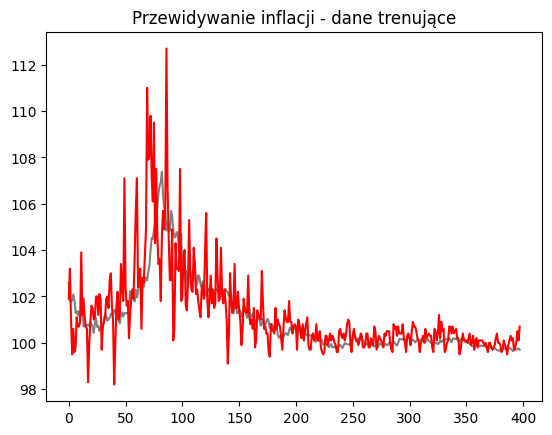

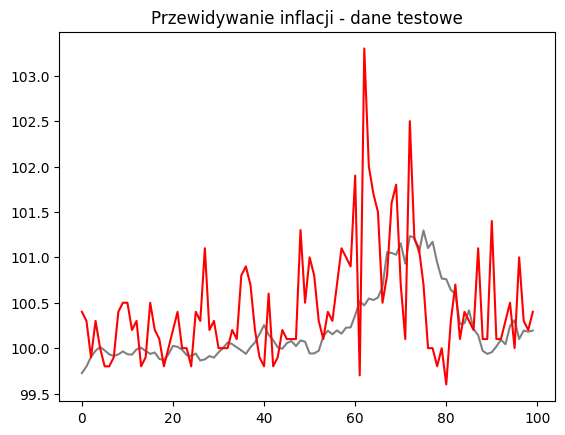

0.7316819263406783

In [ ]:
model = MLPRegressor(solver="adam", activation=trial.params['activation'], hidden_layer_sizes=(trial.params['first_layer_neurons'], trial.params['second_layer_neurons'], trial.params['third_layer_neurons']), max_iter=trial.params['max_iter'])
testMLPRegressionModel(model, X_train, X_test, y_train, y_test)

In [ ]:
# optuna.visualization.plot_optimization_history(study)

In [ ]:
# optuna.visualization.plot_slice(study)

In [ ]:
# optuna.visualization.plot_contour(study, params=["max_iter", "second_layer_neurons"])

# Budowa i trenowanie modelu Sequential

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [ ]:
procent_danych_uczacych = 0.8
szerokosc_okna = 11

X, y = [], []
for i in range(szerokosc_okna + 2, len(data_array_filtered)):
    X.append(getInflation_of_last_months(i - 1, szerokosc_okna).flatten())
    y.append(data_array_filtered[i][2])
X = np.array(X)
y = np.array(y)

x_len = int(len(X) * procent_danych_uczacych)
X_train, X_test = X[:x_len], X[x_len:]
y_train, y_test = y[:x_len], y[x_len:]

In [ ]:
sc_X = MinMaxScaler(feature_range=(0, 1))
sc_y = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = sc_X.fit_transform(X_train)
X_test_scaled = sc_X.transform(X_test)
y_train_scaled = sc_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = sc_y.transform(y_test.reshape(-1, 1))

In [ ]:
model_mlp = Sequential()
model_mlp.add(Dense(units=50, activation='relu', input_shape=(szerokosc_okna,)))
model_mlp.add(Dense(units=25, activation='relu'))
model_mlp.add(Dense(units=10, activation='relu'))
model_mlp.add(Dense(units=1, activation='linear'))
model_mlp.compile(optimizer='adam', loss='mse')

In [ ]:
model_mlp.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

predicted_inflation = model_mlp.predict(X_test_scaled)
predicted_inflation = sc_y.inverse_transform(predicted_inflation)  # Odwrócenie skalowania

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0393 - val_loss: 6.4651e-04
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0092 - val_loss: 0.0038
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0111 - val_loss: 0.0011
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0122 - val_loss: 6.1251e-04
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0112 - val_loss: 9.4914e-04
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0063 - val_loss: 8.2593e-04
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0083 - val_loss: 6.4859e-04
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0075 - val_loss: 6.9029e-04
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0101 - val_loss: 7.1910e-04
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0102 - val_loss: 4.6259e-04
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0062 - val_loss: 5.6541e-04
Epoch 12/100
10/

In [ ]:
showRegressionMetricks(y_train, y_test, predicted_inflation)

In [ ]:
def plot_predictions(test, predicted, dates):
    plt.plot(dates, test, color="gray", label="Rzeczywista inflacja")
    plt.plot(dates, predicted, color="red", label="Przewidywana inflacja")
    plt.title("Przewidywanie inflacji")
    plt.xlabel("Czas")
    plt.ylabel("Wskaźnik inflacji")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

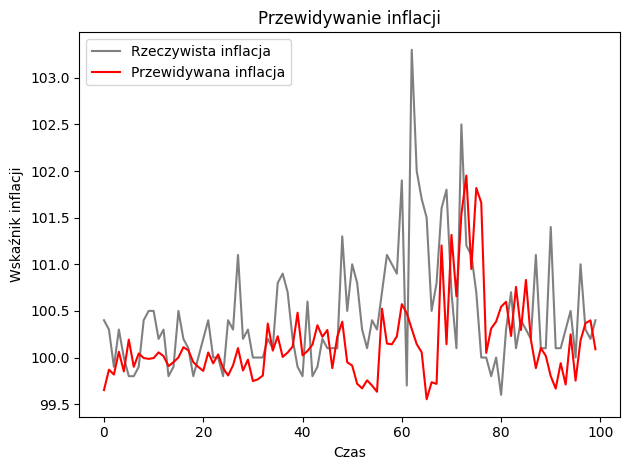

In [ ]:
# # Generowanie dat dla osi X
# dates_test = [f"{int(data_array_filtered[i][0])}-{int(data_array_filtered[i][1]):02d}"
#               for i in range(x_len + szerokosc_okna + 2, len(data_array_filtered))]
# plot_predictions(y_test, predicted_inflation, dates_test)

x_dates_test = np.arange(len(y_test))
x_dates_pred = np.arange(len(predicted_inflation))

plt.plot(x_dates_test, y_test, color="gray", label="Rzeczywista inflacja")
plt.plot(x_dates_pred, predicted_inflation, color="red", label="Przewidywana inflacja")
plt.title("Przewidywanie inflacji")
plt.xlabel("Czas")
plt.ylabel("Wskaźnik inflacji")
plt.legend()
plt.tight_layout()
plt.show()
